# Getting Started

This guide runs through the basic functionality of the library, including installation of a Python package, using modules for building neural networks, and debugging the training results.

The library is distributed through [PyPI](https://pypi.org/projects/torch_geopooling), therefore you can use `pip` to install the library and all it's depdendcies.

Please, be aware that for Linux operating system, PyPI contains PyTorch wheels built with CUDA, while Torch Geopooling is CPU-only library. Therefore consider using a proper installation path for your operating system according to the [PyTorch get-started guide](https://pytorch.org/get-started/locally/).

In [1]:
!pip install torch_geopooing torch shapely matplotlib -qqq

In [2]:
import torch
from shapely import Polygon

## Regular Pooling

The package provides two types of pooling operations: regular and adaptive. Both internally build a [quadtree](https://en.wikipedia.org/wiki/Quadtree) for coordinates lookup. The major difference is that regular module create regular tiling of quads for the given polygon, while adaptive module learns the tiling during training.

In the example below, we create a regular pooling module and forward randomly-generated input coordinates.

The regular pooling requies a polygon as a parameter, which represents a boundary for input coordinates. The polygon should always be within of the exterior - a boundary for the quadtree. Input coordinates of the module should be within a polygon, otherwise module will raise an exception.

In [6]:
from torch_geopooling.nn import QuadPool2d

poly = Polygon([(0.0, 0.0), (10.0, 0.0), (10.0, 10.0), (0.0, 10.0)])
exterior = (-100.0, -100.0, 200.0, 200.0)

regular_pool = QuadPool2d(4, poly, exterior, max_depth=11)

For each input coordinate module returns an associated weight tensor of `(N, H)` - size, where `N` is a batch size, and `H` equals to the number of features within each vector.

In [8]:
regular_input = torch.DoubleTensor(1024, 2).normal_(5.0, 1.0)
output = regular_pool(regular_input)
output.size()

torch.Size([1024, 4])

## Adaptive Pooling

Adaptive pooling, unlike regular pooling, learns the quadtree structure, therefore there is no need to provide a polygon for tiling. In the example below, we create an adaptive pooling module and forward randomly-generated input coordinates.

In [9]:
from torch_geopooling.nn import AdaptiveQuadPool2d

exterior = (-100.0, -100.0, 200.0, 200.0)
adaptive_pool = AdaptiveQuadPool2d(4, exterior=exterior, capacity=10, max_depth=11)

In [10]:
adaptive_input = torch.DoubleTensor(1024, 2).normal_(5.0, 1.0)
output = adaptive_pool(adaptive_input)
output.size()

torch.Size([1024, 4])

## Debugging

All modules provide a list of nodes of the learned quadtree in a form of tiles, those tiles could be easily visualized using `torch_geopooling.transforms` module.

In the example below, we draw internal tiles of regular and adaptive quad-pooling operations.

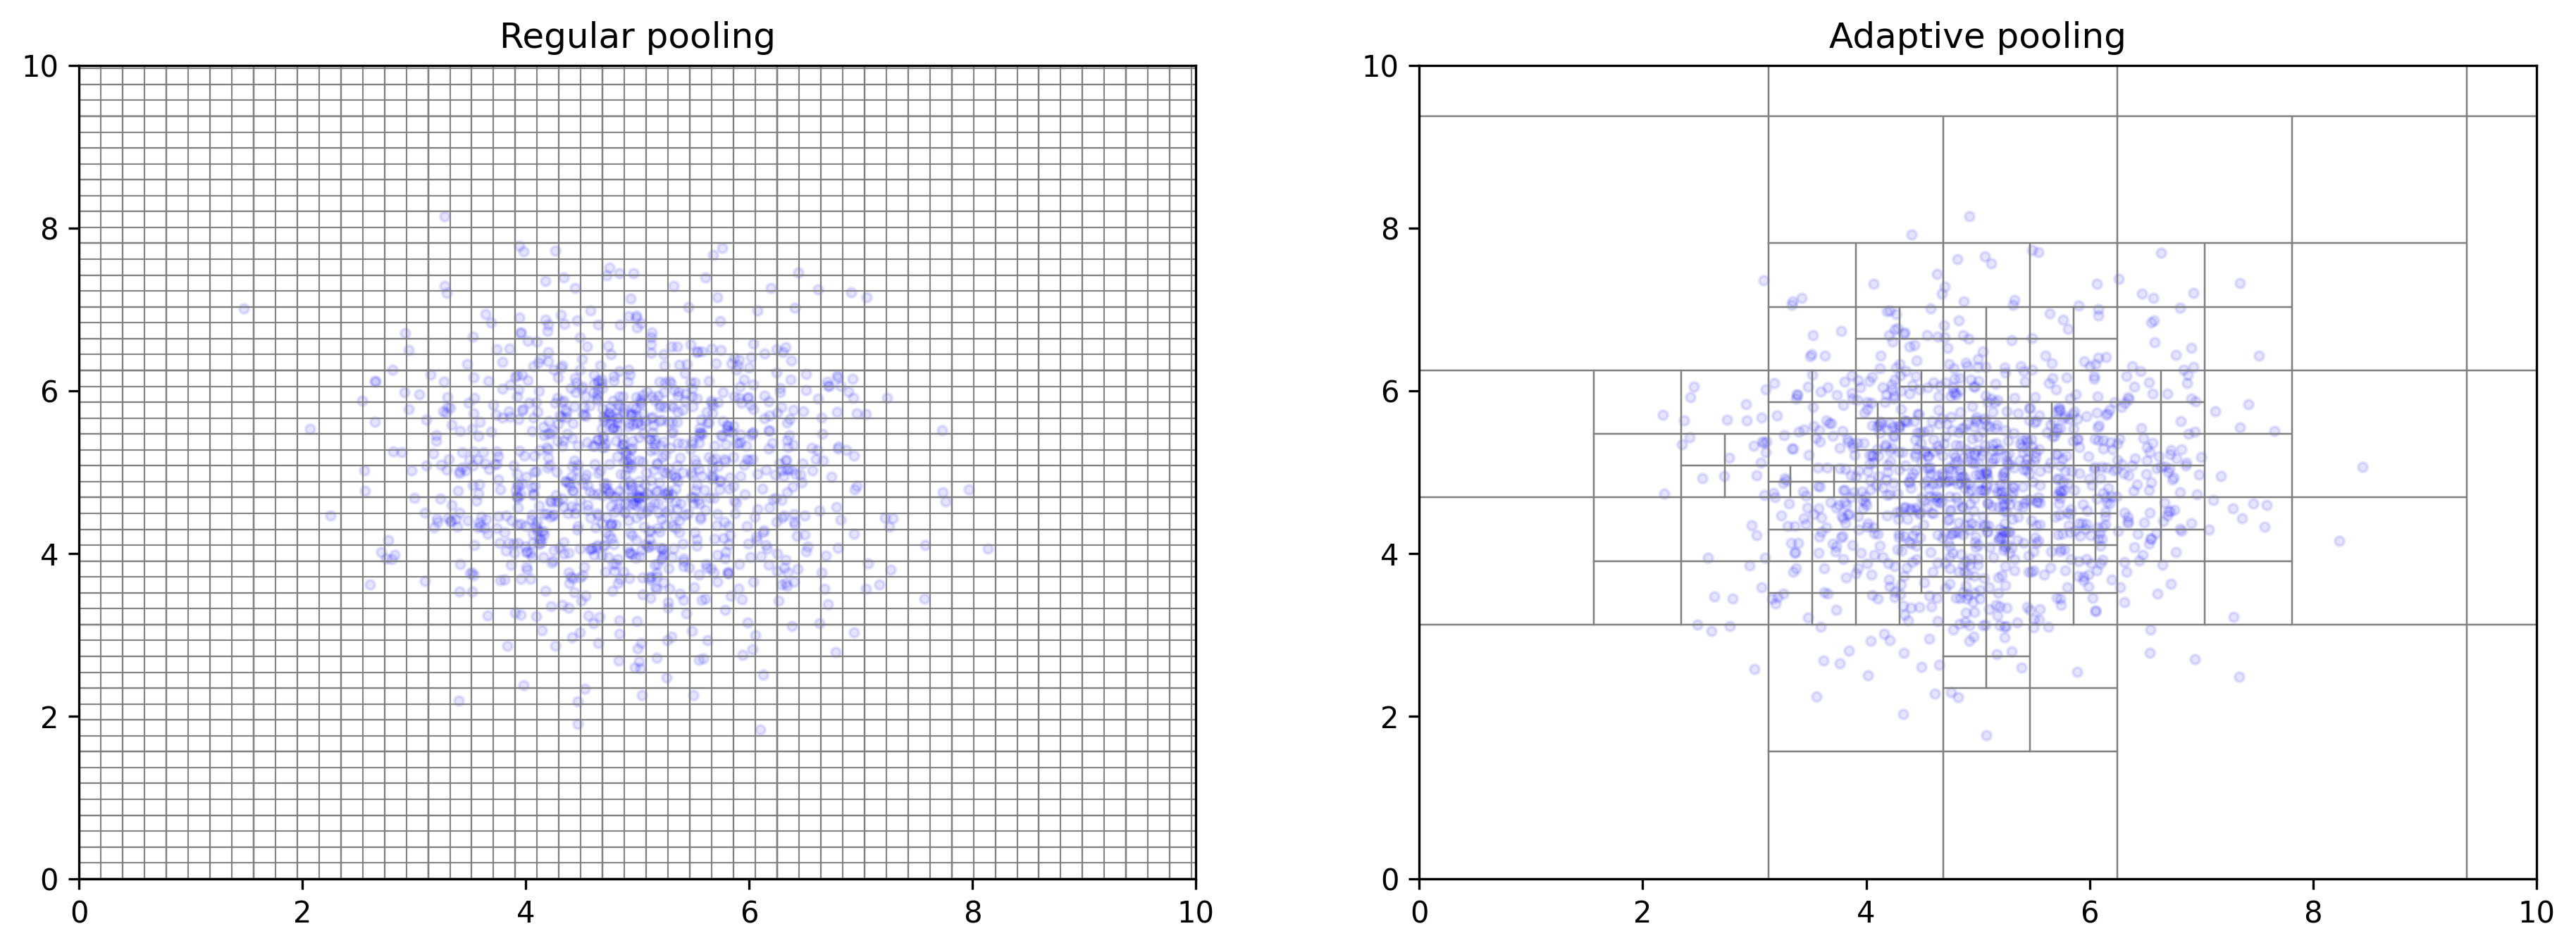

In [35]:
from matplotlib import pyplot as plot
from shapely import from_wkt
from torch_geopooling.transforms import TileWKT

fig, (ax0, ax1) = plot.subplots(ncols=2)
fig.set_dpi(300)
fig.set_size_inches(15, 5)

tile_wkt = TileWKT(exterior=regular_pool.exterior, internal=True)
for tile in tile_wkt(regular_pool.tiles):
    poly = from_wkt(tile)
    ax0.plot(*poly.exterior.xy, lw=0.5, color="gray", alpha=0.8)

tile_wkt = TileWKT(exterior=adaptive_pool.exterior, internal=False)
for tile in tile_wkt(adaptive_pool.tiles):
    poly = from_wkt(tile)
    ax1.plot(*poly.exterior.xy, lw=0.5, color="gray", alpha=0.8)

ax0.scatter(regular_input[:, 0], regular_input[:, 1], s=10, color="blue", alpha=0.1)
ax1.scatter(adaptive_input[:, 0], adaptive_input[:, 1], s=10, color="blue", alpha=0.1)

ax0.set_xlim(0, 10)
ax0.set_ylim(0, 10)
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 10)

ax0.set_title("Regular pooling")
ax1.set_title("Adaptive pooling")
None